# Homework 4

This is a homework assignment on the material about the `Variance reduction techniques and Distributed Optimisation basic ideas`. 

__Soft Deadline__: +2 weeks after the release date: __5 Dec 2024, 23:59__

<span style="color:red">__Soft Deadline__ = __Hard Deadline__</span>. 

- The homework is done in the same Jupyter Notebook. *Please, read all problems first, then decide how to distribute your time. The homework is interesting, but a bit time consuming!*
- The submission should be in the following format: **YourName_HW4.ipynb**.
- Do not forget to add necessary explanations and comments.
- You are free to modify the function templates and use additional libraries. However, do not use built-in functions if the assignment requires you to implement the method from scratch.


- __The works will be checked for plagiarism. The score will be divided by the number of similar works.__

- A full run of the solution (Kernel -> Restart & Run All) should run all cells without errors.

- The maximum score for the assignment is `20 + 6 (bonus)`.
_To get a full score for the hometask you need to get 20._

We wish you success!

## Variance Reduced SGD 

***We continue to work with the stochastic optimisation of LogReg (:***

\begin{equation}
\min_{w \in \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n \ell (g(w, x_i), y_i) + \frac{\lambda}{2} \| w\|^2_2,
\end{equation}
where $\ell: \mathbb{R} \times \mathbb{R} \to \mathbb{R}$ is a loss function, $g : \mathbb{R}^d \times \mathbb{R}^x \to \mathbb{R}$ is a model, $w$ are parameters of the model, $\{x_i, y_i\}_{i=1}^n$ is data of objects $x_i \in \mathbb{R}^x$ and labels $y_i \in \mathbb{R}$.

We use the linear model $g(w, x) = w^T x$ and the logistic/sigmoid loss function: $\ell(z,y) = \ln (1 + \exp(-yz))$ (__Important: $y$ must take values $-1$ or $1$__). As we already know, the resulting problem is called a logistic regression problem.

This problem can be rewritten as follows:
\begin{equation}
\min_{w \in \mathbb{R}^d} f(w) := \frac{1}{s} \sum\limits_{j=1}^s f_j(w) := \frac{1}{s} \sum\limits_{j=1}^s \left[\frac{1}{b} \sum\limits_{i=1}^b l (g(w, x_{(j-1)b + i}), y_{(j-1)b + i}) + \frac{\lambda}{2} \| w\|^2_2\right],
\end{equation}
where $b$ is the batch size, $s$ is the number of batches, and $b s = n$ is the total sample size.

The gradient of $f_j$:
$$
\nabla f_j(w) = \frac{1}{b} \sum_{i=1}^b \frac{-y_{(j-1)b + i} x_{(j-1)b + i}}{1 + \exp(y_{(j-1)b + i} w^Tx_{(j-1)b + i})}.
$$
The Lipschitz constant of the gradient $\nabla f_j$ can be estimated as $L_j = \frac{1}{4b} \sum\limits_{i=1}^b \| x_{(j-1)b + i} \|^2_2$.

We continue to work with _mushrooms_ dataset.

In [11]:
dataset = "mushrooms.txt"
#the file must be in the same directory as notebook.

In [4]:
from sklearn.datasets import load_svmlight_file
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]

Let us change the vector $y$ so that $y_i$ takes values $-1$ and $1$. You can also do additional preprocessing of the data (with techniques from machine learning), but this is not additionally assessed in any way.

In [5]:
y = 2 * y - 3

Let us divide the data into two parts: training and test.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

For the training part $X_{train}$, $y_{train}$, estimate the constant $L$. Set $\lambda$ such that $\lambda \approx L / 1000$.  Realize in the code the calculation of the value and gradient for our target function ($X$, $y$, $\lambda$ should be given as a parameter so that it is possible to change them, not only to substitute fixed $X_{train}$, $y_{train}$). You can use ``numpy``, or ``autograd``, ``pytorch``, ``jax``.

In [80]:
! pip install autograd

Consider a given batch, $X_{b, j}$
Then, $L_j = \frac{1}{4b} \sum\limits_{i=1}^b \| x_{(j-1)b + i} \|^2_2 = \frac{1}{4b} \sum\limits_{i=1}^b x_{(j-1)b + i}^Tx_{(j-1)b + i} = \frac{1}{4b}\text{trace}(X_{b, j}^TX_{b, j})$

In [30]:
#your solution (Code and Markdown)
import numpy as np
# To estimate L from train sets
L = np.trace(X_train.T @ X_train)/(4*X_train.shape[0])

In [87]:
regularizer = L/1000 # lambda 

def L_estimate(batch = X_train):
    return np.trace(batch.T @ batch)/(4*batch.shape[0])

def cost(w, x, y, regularizer = regularizer):
    '''
    Evaluates the cost function

    Parameters
    w:           numpy array containing weights of the model
    x:           numpy array containing features of the data point
    y:           numpy array containing class labels for each data point
    regularizer: user defined parameter for regularising

    Returns:
    loss: the value of the cost function of a data batch for a given set of weights
    '''
    n = len(y)
    loss = 0
    g = (x @ w).flatten()
    y = y.flatten()
    for i in range(n):
        l = np.log(1 + np.exp(-y[i]*g[i]))
        loss += l
    loss /= n
    loss += regularizer * np.sum(w.T @ w)
    return loss

import autograd
import autograd.numpy as anp

def cost1(w, x, y, regularizer = regularizer):
    '''
    Evaluates the cost function

    Parameters
    w:           autograd.numpy array containing weights of the model
    x:           autograd.numpy array containing features of the data point
    y:           autograd.numpy array containing class labels for each data point
    regularizer: user defined parameter for regularising

    Returns:
    loss: the value of the cost function of a data batch for a given set of weights
    '''
    n = len(y)
    loss = 0
    g = (x @ w).flatten()
    y = y.flatten()
    for i in range(n):
        l = anp.log(1 + anp.exp(-y[i]*g[i]))
        loss += l
    loss /= n
    loss += regularizer * anp.sum(w.T @ w)
    return loss

formula = False
def gradient(w, x, y, formula = formula, regularizer = regularizer):
    '''
    Evaluates the gradient function

    Parameters
    w:           numpy array containing weights of the model
    x:           numpy array containing features of the data point
    y:           numpy array containing class labels for each data point
    regularizer: user defined parameter for regularising

    Returns:
    grad: the value of the gradient function of a data batch for a given set of weights
    '''
    # def dfdx_i(f: callable, 
    #            x: np.ndarray,
    #            i=0,
    #            eps=1e-3
    #           ):
    #     out = np.zeros_like(x)
    #     out[i] = eps
    #     return (f(x + out) - f(x - out))/2/eps
        
    f = lambda w: cost1(w, x, y)
    if formula:
        g = (x @ w).flatten()
        grad = np.zeros_like(x[0])
        for i in range(len(y)):
            denominator = 1 + np.exp(y[i] * g[i])
            numerator = - y[i] * x[i]
            grad += numerator / denominator
        grad += regularizer * w              # Similar mistake with previous HW, so I added the missing lambda
        return grad
    else:
        # grad = [dfdx_i(f, np.zeros_like(x[0]), i) for i in range(len(x[0]))]  Too slow
        # grad += regularizer * w
        return autograd.grad(f)(w)                                            # Faster

def predict(w, x):
    '''
    Predicts the class, given a set of weights and features
    
    Parameters
    w:           numpy array containing weights of the model
    x:           numpy array containing features of the data point

    Returns:
    y_pred: numpy array of predicted labels
    '''
    g = w.T @ x
    y_pred = (g >= 0) + (g < 0)*-1
    return y_pred.flatten()

In [82]:
import time
start = time.time()
gradient(np.zeros_like(X_train[0]), X_train, y_train, formula = True)
end = time.time()
print(end-start)
start = time.time()
gradient(np.zeros_like(X_train[0]), X_train, y_train, formula = False)
end = time.time()
print(end-start)

0.10648012161254883
1.1437768936157227


**$\textcolor{red}{Pre-setup}$**

Please, put in the cell bellow the batch splitting procedure from the previous assignment here:

In [27]:
# Just BATCH IT!

def split_data(b: int, data: tuple[np.array] = (X_train, y_train)) -> list:
    '''
    Parameters:
    b: Batchsizes of each data
    data: Tuple of numpy arrays

    Returns:
    out: list of tuples of numpy arrays
    '''
    out = []
    for i in range(0, len(data[1]), b):
        out.append((data[0][i: i+b], data[1][i: i+b]))
    return tuple(out)

**Problem 1. (2 points)**

Implement the SGD method `with momentum` **(1 point)**:
\begin{equation}
\begin{aligned}
    &w^{k+1} = w^{k} - \gamma g^{k} \\
    &g^{k+1} = (1 - b) g^{k} + b \nabla f_{j_k}(w^{k+1}),
\end{aligned}
\end{equation}
    
where the number $j_k$ is generated independently and uniformly from $\{1, \ldots, s \}$,
$b \in [0, 1]$ is a *momentum* parameter.

For the tasks below, you may need to be able to measure the running time of the method.

In [126]:
# your solution
import time
from tqdm import tqdm
import random

def Momentum_SGD(nabla_f, w_0, gamma, beta, b,
                K = 1000, eps = 1e-6, data = (X_train, y_train)):
    '''
    Finds the zero of nabla_f using stochastic gradient descent with momentum

    Parameters
    nabla_f:   Gradient of the cost function
    w_0    :   Start point
    gamma  :   Learning rate
    beta   :   Hyper parameter for momentum
    b      :   Batch size
    K      :   Number if iterations
    eps    :   Accuracy
    data   :   Data to train the algorithm on

    Return
    w_opt  :   Optimal point found by the algorithm
    path   :   The path of the algorithm = [norm(w_0), norm(w_1), ..., norm(w_K)]
    '''
    start = time.time()
    batches = split_data(b, data)
    s = len(batches)
    g_prev = np.random.rand(X_train[0].shape[0])
    w_prev = w_0
    path = []
    C = np.linalg.norm(nabla_f(w_0, data[0], data[1]))
    for k in tqdm(range(K)):
        batch = batches[random.randint(0, s-1)]
        w_new = w_prev - gamma(k) * g_prev
        # gradient(w, x, y)
        g_new = (1 - beta) * g_prev + beta * nabla_f(w_new, batch[0], batch[1])
        path.append(np.linalg.norm(w_new - w_prev)/C)
        if np.all(np.abs(w_new - w_prev) <= eps):
            break
        w_prev = w_new
        g_prev = g_new
    w_opt = w_new
    end = time.time()
    print(f'SGD implementation with Momentum for batchsize {b}, beta {beta}, took {end - start} seconds')
    return w_opt, path

And implement the `MVR` variant of SGD **(1 point)**:
\begin{equation}
\begin{aligned}
    &w^{k+1} = w^{k} - \gamma g^{k} \\
    &g^{k+1} = (1 - b) g^{k} + b \nabla f_{j_k}(w^{k+1}) + \textcolor{cyan}{(1 - b) \left(\nabla f_{j_k}(w^{k+1}) - \nabla f_{j_k}(w^{k})\right)}
\end{aligned}
\end{equation}

Don't forget about time measurements

In [125]:
# your solution

def MVR_SGD(nabla_f, w_0, gamma, beta, b,
            K = 1000, eps = 1e-6, data = (X_train, y_train)):
    '''
    Finds the zero of nabla_f using stochastic gradient descent with momentum

    Parameters
    nabla_f:   Gradient of the cost function
    w_0    :   Start point
    gamma  :   Learning rate
    beta   :   Hyper parameter for momentum
    b      :   Batch size
    K      :   Number if iterations
    eps    :   Accuracy
    data   :   Data to train the algorithm on

    Return
    w_opt  :   Optimal point found by the algorithm
    path   :   The path of the algorithm = [norm(w_0), norm(w_1), ..., norm(w_K)]
    '''
    start = time.time()
    batches = split_data(b, data)
    s = len(batches)
    g_prev = np.random.rand(X_train[0].shape[0])
    w_prev = w_0
    C = np.linalg.norm(nabla_f(w_0, data[0], data[1]))
    path = []
    for k in tqdm(range(K)):
        batch = batches[random.randint(0, s-1)]
        w_new = w_prev - gamma(k) * g_prev
        # gradient(w, x, y)
        nab_w1 = nabla_f(w_new, batch[0], batch[1])
        nab_w0 = nabla_f(w_prev, batch[0], batch[1])
        g_new = (1 - beta) * g_prev + beta * nab_w1  + (1 - beta) * (nab_w1 - nab_w0)
        path.append(np.linalg.norm(w_new - w_prev)/C)
        if np.all(np.abs(w_new - w_prev) <= eps):
            break
        w_prev = w_new
        g_prev = g_new
    w_opt = w_new
    end = time.time()
    print(f'MVR SGD implementation for batchsize {b}, beta {beta}, took {end - start} seconds')
    return w_opt, path

**Problem 2. (4 points + 2 bonus)**

Great!

Now, using the existing implementation of SGD from the previous assignment...  

In [124]:
# Put SGD from the previous assignment here
def SGD(nabla_f, w_0, gamma, b,
        K = 1000, eps = 1e-6, data = (X_train, y_train)):
    '''
    Finds the zero of nabla_f using stochastic gradient descent with momentum

    Parameters
    nabla_f:   Gradient of the cost function
    w_0    :   Start point
    gamma  :   Learning rate
    b      :   Batch size
    K      :   Number if iterations
    eps    :   Accuracy
    data   :   Data to train the algorithm on

    Return
    w_opt  :   Optimal point found by the algorithm
    path   :   The path of the algorithm = [norm(w_0), norm(w_1), ..., norm(w_K)]
    '''
    start = time.time()
    batches = split_data(b, data)
    s = len(batches)
    w_prev = w_0
    C = np.linalg.norm(nabla_f(w_0, data[0], data[1]))
    path = []
    for k in tqdm(range(K)):
        batch = batches[random.randint(0, s-1)]
        w_new = w_prev - gamma(k) * nabla_f(w_prev, batch[0], batch[1])
        
        path.append(np.linalg.norm(w_new - w_prev)/C)
        if np.all(np.abs(w_new - w_prev) <= eps):
            break
        w_prev = w_new
    w_opt = w_new
    end = time.time()
    print(f'SGD implementation for batchsize {b}, took {end - start} seconds')
    return w_opt, path

*(1 points)*

Solve the optimization problem on the training sample using the implemented methods: `SGD, SGD+Momentum, MVR`.

Take again: $\text{batch\_size } = 10$,$\gamma_k \equiv \frac{1}{L}$. Draw the convergence plot wtih the same criteria (e.g. $\frac{\| \nabla f(w^k)\|}{\| \nabla f(w^0)\|}$) from the iteration number. 

Make a conclusions about the reduction of variance for 2 modifications.

Do we see the biased behaviour for the MVR here? Why? 

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 577.87it/s]


SGD implementation for batchsize 10, took 3.107787847518921 seconds


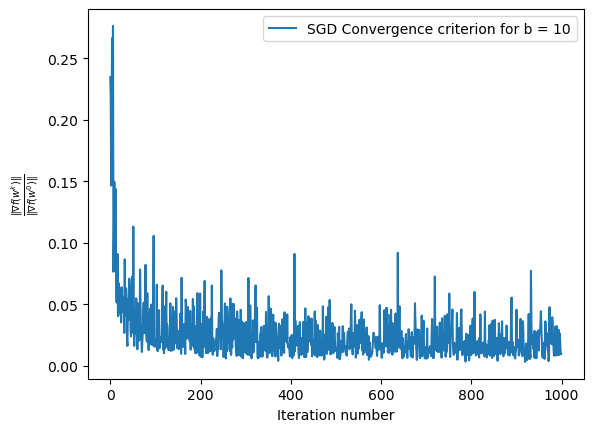

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 635.33it/s]


SGD implementation with Momentum for batchsize 10, beta 0.2, took 3.070296049118042 seconds


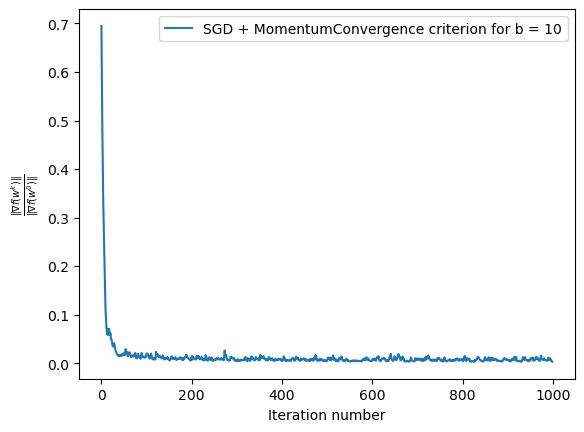

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 291.71it/s]


MVR SGD implementation for batchsize 10, beta 0.2, took 4.681146621704102 seconds


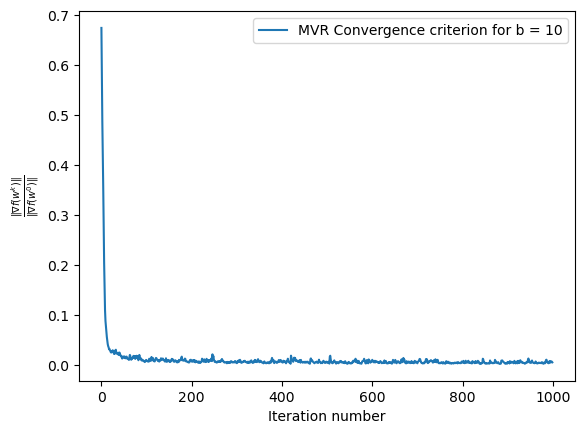

In [127]:
# your solution here
import matplotlib.pyplot as plt
%matplotlib inline

b = 10
gamma = lambda x: 1/L
w_0 = np.random.rand(X_train[0].shape[0])

w_opt1, path1 = SGD(nabla_f = gradient, w_0 = w_0, gamma = gamma, b = b)
x_cord1 = [i for i in range(len(path1))]
plt.plot(x_cord1, path1, label = f'SGD Convergence criterion for b = {b}')
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.legend()
plt.show()

beta = 0.2

w_opt2, path2 = Momentum_SGD(nabla_f = gradient, w_0 = w_0, gamma = gamma, beta = beta, b = b)
x_cord2 = [i for i in range(len(path2))]
plt.plot(x_cord2, path2, label = f'SGD + MomentumConvergence criterion for b = {b}')
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.legend()
plt.show()

w_opt3, path3 = MVR_SGD(nabla_f = gradient, w_0 = w_0, gamma = gamma, beta = beta, b = b)
x_cord3 = [i for i in range(len(path3))]
plt.plot(x_cord3, path3, label = f'MVR Convergence criterion for b = {b}')
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.legend()
plt.show()

For this batch size, there is observable difference difference between MVR and Momentum in terms of variance of the convergence (although little). MVR seems to be the slowest.

*(1.6 points)*

When you understand that the implementation works ~~somehow~~, repeat the research (from the previous assignment) of hyperparameters for all 3 methods and compare them.

- $\text{batch\_size}: 1, 10, 100, 1000$, $\gamma_k \equiv \frac{1}{L}$ with the standart convergence criteria (previous one) from the iterations
- same for the criteria from the oracle calls (the amount of gradient calls on batch) or time
- $\text{batch\_size}= 10$, $\gamma_k: \frac{1}{L}, \frac{1}{\sqrt{k + 1}}, \gamma_k = \frac{1}{k + 1}$.

Can you see something interesting now? Is the varience really reduced?

How does the variance reduction influence the time dependency?
Any other thoughts?...

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:47<00:00, 2118.25it/s]


SGD implementation for batchsize 1, took 48.70772409439087 seconds


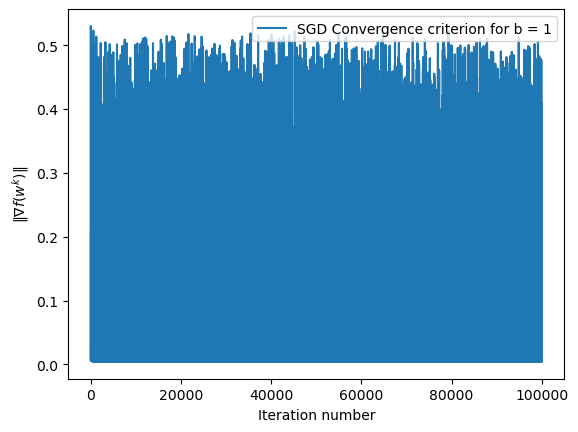

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:48<00:00, 2060.87it/s]


SGD implementation with Momentum for batchsize 1, beta 0.2, took 50.05978798866272 seconds


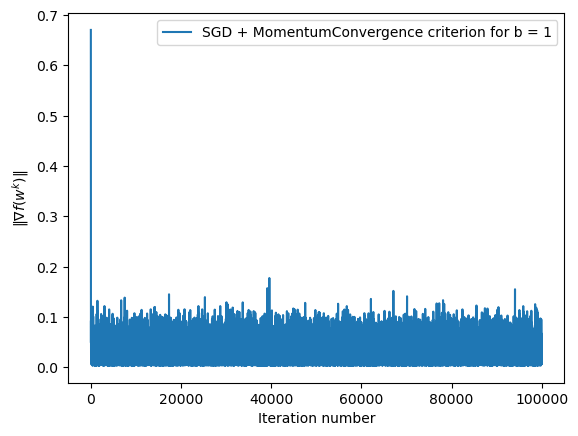

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [01:36<00:00, 1034.04it/s]


MVR SGD implementation for batchsize 1, beta 0.2, took 98.03397798538208 seconds


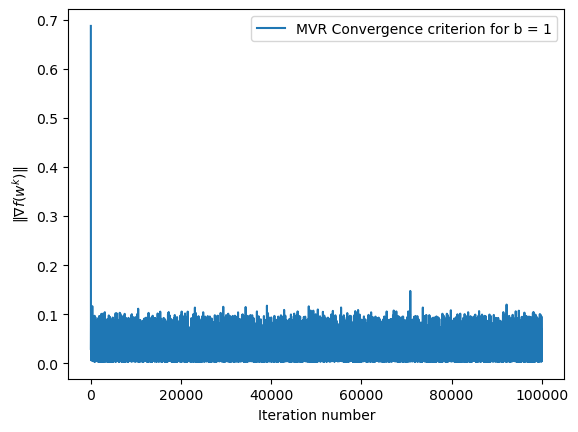

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [02:48<00:00, 592.94it/s]


SGD implementation for batchsize 10, took 170.0189516544342 seconds


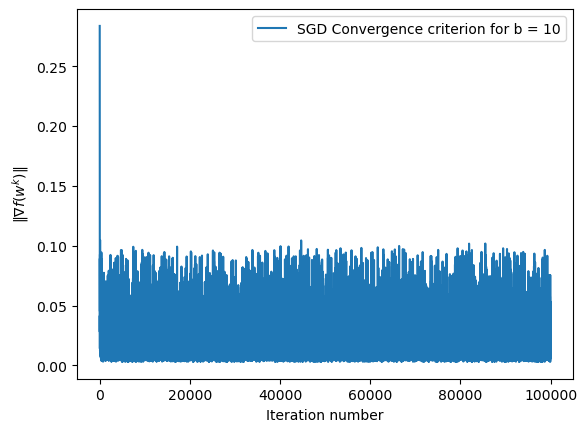

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [02:34<00:00, 648.26it/s]


SGD implementation with Momentum for batchsize 10, beta 0.2, took 156.02814412117004 seconds


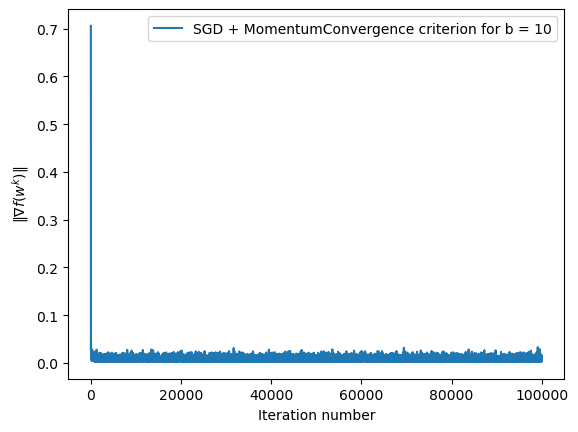

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [04:53<00:00, 340.63it/s]


MVR SGD implementation for batchsize 10, beta 0.2, took 294.82218074798584 seconds


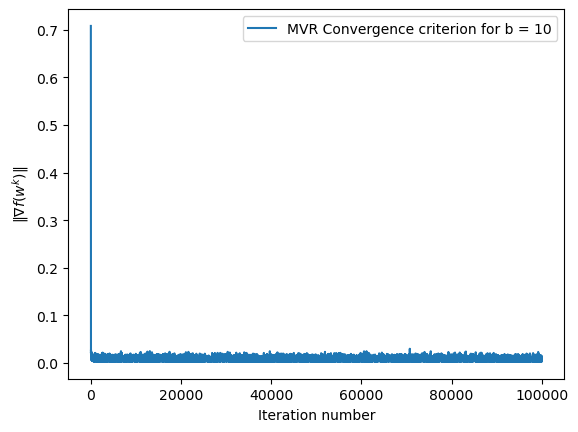

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [37:59<00:00, 43.86it/s]


SGD implementation for batchsize 100, took 2281.1342685222626 seconds


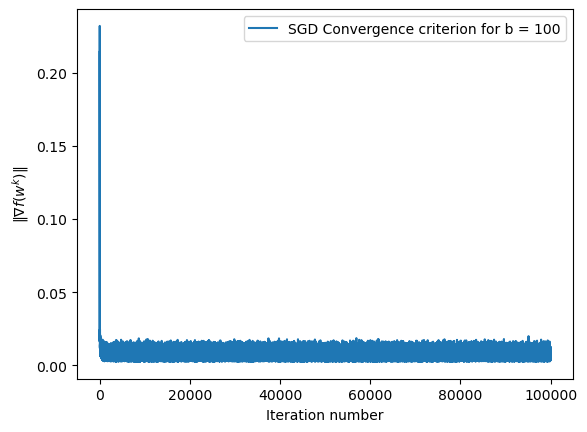

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [38:57<00:00, 42.78it/s]


SGD implementation with Momentum for batchsize 100, beta 0.2, took 2339.245301961899 seconds


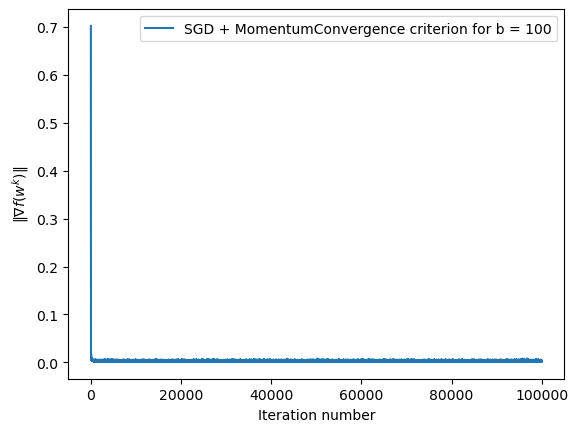

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [1:10:35<00:00, 23.61it/s]


MVR SGD implementation for batchsize 100, beta 0.2, took 4236.628452777863 seconds


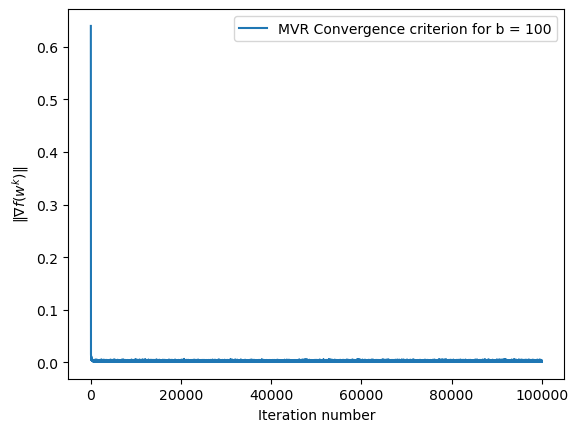

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [9:53:46<00:00,  2.81it/s]


SGD implementation for batchsize 1000, took 35627.778695106506 seconds


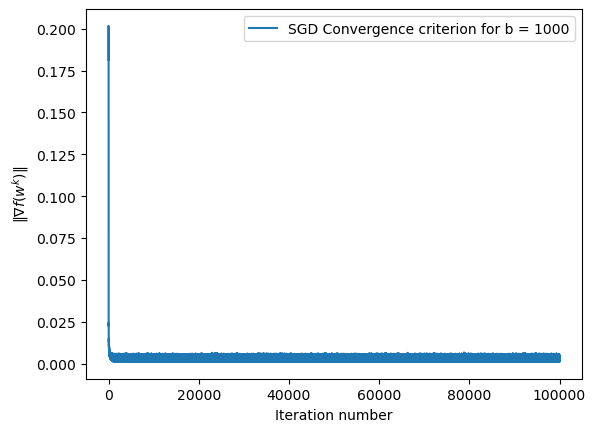

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [7:01:24<00:00,  3.95it/s]


SGD implementation with Momentum for batchsize 1000, beta 0.2, took 25286.291654109955 seconds


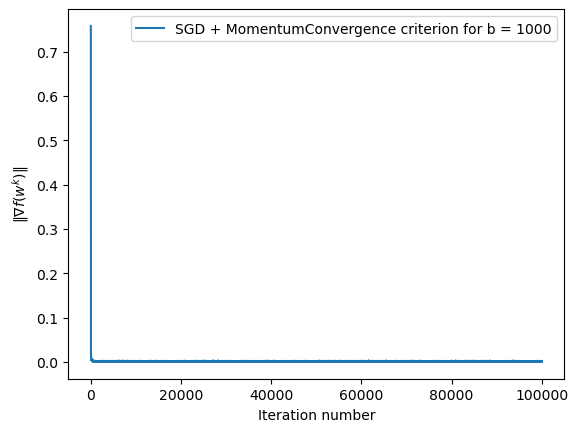

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [13:35:40<00:00,  2.04it/s]


MVR SGD implementation for batchsize 1000, beta 0.2, took 48941.956317424774 seconds


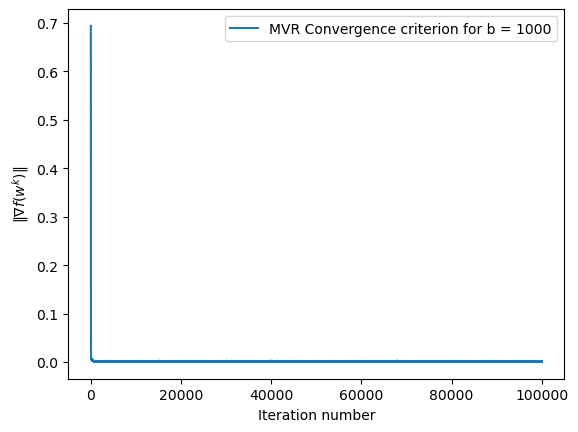

In [131]:
# your solution here
import math
def tests(b = 10, gamma = lambda x: 1/L, beta = 0.2, K = 100_000):
    w_0 = np.random.rand(X_train[0].shape[0])
    
    w_opt1, path1 = SGD(nabla_f = gradient, w_0 = w_0, gamma = gamma, b = b, K = K)
    x_cord1 = [i for i in range(len(path1))]
    plt.plot(x_cord1, path1, label = f'SGD Convergence criterion for b = {b}')
    plt.xlabel('Iteration number')
    plt.ylabel('$ \\| \\nabla f (w^k) \\| $')
    plt.legend()
    plt.show()
    
    w_opt2, path2 = Momentum_SGD(nabla_f = gradient, w_0 = w_0, gamma = gamma, beta = beta, b = b, K = K)
    x_cord2 = [i for i in range(len(path2))]
    plt.plot(x_cord2, path2, label = f'SGD + MomentumConvergence criterion for b = {b}')
    plt.xlabel('Iteration number')
    plt.ylabel('$ \\| \\nabla f (w^k) \\| $')
    plt.legend()
    plt.show()
    
    w_opt3, path3 = MVR_SGD(nabla_f = gradient, w_0 = w_0, gamma = gamma, beta = beta, b = b, K = K)
    x_cord3 = [i for i in range(len(path3))]
    plt.plot(x_cord3, path3, label = f'MVR Convergence criterion for b = {b}')
    plt.xlabel('Iteration number')
    plt.ylabel('$ \\| \\nabla f (w^k) \\| $')
    plt.legend()
    plt.show()

batch_size = [1, 10, 100, 1000]
for b in batch_size:
    tests(b)

_(1.4 points + 2 bonus points)_

Now, decide what type of plots do you want to analyse:
- Accuracy (as from the first assignment)
- Same criteria as from the previous point

Using the selected type of plots, try to understand, how the `momentum parameter` influences on the behaviour of convergence `for SGD+momentum & MVR only`.  

The ideas for search:
- $b = 0.1$ is proposed as working well for many algorithms. You can propose to plot the relative characteristics of convergency rate
- Take the logarithmically scaled range of $b$ and plot the reached criteria after *fixed amount of iterations* for both methods from the $b$

***1.4 points*** for the basic idea reproduction:
- visualise plots from the previous point (changing $\text{batch\_size}$ and $\gamma_k$, without a second plot with oracle calls/time) for somehow seleceted $b$'s. 
- make the conclusions

***up to 2 bonus points***: for the interesting ideas of visualisation (you can choose one from the proposed), for the justified procedure of momentum selection (maybe, found in the article - then provide it), for any kind of additional conclusions

In [ ]:
# JUST DO IT! It will be breathtaking :)
# your solution here

### Solving the distributed optimization problem

**AGAIN ...**

Consider again the empirical risk minimization:
\begin{equation}
\min_{w \in \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n \ell (g(w, x_i), y_i) + \frac{\lambda}{2} \| w\|^2_2,
\end{equation}
where $\ell: \mathbb{R} \times \mathbb{R} \to \mathbb{R}$ is a loss function, $g : \mathbb{R}^d \times \mathbb{R}^x \to \mathbb{R}$ is a model, $w$ are parameters of the model, $\{x_i, y_i\}_{i=1}^n$ is data of objects $x_i \in \mathbb{R}^x$ and labels $y_i \in \mathbb{R}$.

We use the linear model $g(w, x) = w^T x$ and the logistic/sigmoid loss function: $\ell(z,y) = \ln (1 + \exp(-yz))$ (__Important: $y$ must take values $-1$ or $1$__). As we already know, the resulting problem is called a logistic regression problem.

This problem can be rewritten as follows:
\begin{equation}
\min_{w \in \mathbb{R}^d} f(w) := \frac{1}{s} \sum\limits_{j=1}^s f_j(w) := \frac{1}{s} \sum\limits_{j=1}^s \left[\frac{1}{b} \sum\limits_{i=1}^b l (g(w, x_{(j-1)b + i}), y_{(j-1)b + i}) + \frac{\lambda}{2} \| w\|^2_2\right],
\end{equation}
where $b$ is the local data size, $s$ is the number of devices, and $b s = n$ is the total sample size.

The gradient of $f_j$:
$$
\nabla f_j(w) = \frac{1}{b} \sum_{i=1}^b \frac{-y_{(j-1)b + i} x_{(j-1)b + i}}{1 + \exp(y_{(j-1)b + i} w^Tx_{(j-1)b + i})} + \lambda w.
$$
The Lipschitz constant of the gradient $\nabla f_j$ can be estimated as $L_j = \frac{1}{4b} \sum\limits_{i=1}^b \| x_{(j-1)b + i} \|^2_2 + \lambda$.

Let us do some preparation work. The _mushrooms_ dataset is attached. Use the following code to generate a matrix $X$ and vector $y$, which will store the sample $\{x_i, y_i\}_{i=1}^n$:

In [1]:
dataset = "mushrooms.txt" 
#the file must be in the same directory as notebook.

In [2]:
from sklearn.datasets import load_svmlight_file
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]

Let us change the vector $y$ so that $y_i$ takes values $-1$ and $1$. You can also do additional preprocessing of the data (with techniques from machine learning), but this is not additionally assessed in any way.

In [4]:
y = 2 * y - 3

Let us divide the data into two parts: training and test.

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

For the training part $X_{train}$, $y_{train}$, estimate the constant $L$. Set $\lambda$ such that $\lambda \approx L / 1000$.  Realize in the code the calculation of the value and gradient for our target function ($X$, $y$, $\lambda$ should be given as a parameter so that it is possible to change them, not only to substitute fixed $X_{train}$, $y_{train}$). You can use ``numpy``, or ``autograd``, ``pytorch``, ``jax``.

Consider a given batch, $X_{b, j}$
Then, $L_j = \frac{1}{4b} \sum\limits_{i=1}^b \| x_{(j-1)b + i} \|^2_2 = \frac{1}{4b} \sum\limits_{i=1}^b x_{(j-1)b + i}^Tx_{(j-1)b + i} = \frac{1}{4b}\text{trace}(X_{b, j}^TX_{b, j})$

In [ ]:
#your solution (Code and Markdown)

import numpy as np
# To estimate L from train sets
L = np.trace(X_train.T @ X_train)/(4*X_train.shape[0])

regularizer = L/1000 # lambda 

def L_estimate(batch = X_train):
    return np.trace(batch.T @ batch)/(4*batch.shape[0])

def cost(w, x, y, regularizer = regularizer):
    '''
    Evaluates the cost function

    Parameters
    w:           numpy array containing weights of the model
    x:           numpy array containing features of the data point
    y:           numpy array containing class labels for each data point
    regularizer: user defined parameter for regularising

    Returns:
    loss: the value of the cost function of a data batch for a given set of weights
    '''
    n = len(y)
    loss = 0
    g = (x @ w).flatten()
    y = y.flatten()
    for i in range(n):
        l = np.log(1 + np.exp(-y[i]*g[i]))
        loss += l
    loss /= n
    loss += regularizer * np.sum(w.T @ w)
    return loss

import autograd
import autograd.numpy as anp

def cost1(w, x, y, regularizer = regularizer):
    '''
    Evaluates the cost function

    Parameters
    w:           autograd.numpy array containing weights of the model
    x:           autograd.numpy array containing features of the data point
    y:           autograd.numpy array containing class labels for each data point
    regularizer: user defined parameter for regularising

    Returns:
    loss: the value of the cost function of a data batch for a given set of weights
    '''
    n = len(y)
    loss = 0
    g = (x @ w).flatten()
    y = y.flatten()
    for i in range(n):
        l = anp.log(1 + anp.exp(-y[i]*g[i]))
        loss += l
    loss /= n
    loss += regularizer * anp.sum(w.T @ w)
    return loss

formula = False
def gradient(w, x, y, formula = formula, regularizer = regularizer):
    '''
    Evaluates the gradient function

    Parameters
    w:           numpy array containing weights of the model
    x:           numpy array containing features of the data point
    y:           numpy array containing class labels for each data point
    regularizer: user defined parameter for regularising

    Returns:
    grad: the value of the gradient function of a data batch for a given set of weights
    '''
    # def dfdx_i(f: callable, 
    #            x: np.ndarray,
    #            i=0,
    #            eps=1e-3
    #           ):
    #     out = np.zeros_like(x)
    #     out[i] = eps
    #     return (f(x + out) - f(x - out))/2/eps
        
    f = lambda w: cost1(w, x, y)
    if formula:
        g = (x @ w).flatten()
        grad = np.zeros_like(x[0])
        for i in range(len(y)):
            denominator = 1 + np.exp(y[i] * g[i])
            numerator = - y[i] * x[i]
            grad += numerator / denominator
        grad += regularizer * w              # Similar mistake with previous HW, so I added the missing lambda
        return grad
    else:
        # grad = [dfdx_i(f, np.zeros_like(x[0]), i) for i in range(len(x[0]))]  Too slow
        # grad += regularizer * w
        return autograd.grad(f)(w)                                            # Faster


__Problem 0. (2 + bonus 4  points)__ Since we have to deal with a distributed setting, we need to be able to divide the data into parts. The basic variant of this you have most likely already realized in the previous assignment when dividing data into batches. 

In [ ]:
#your solution (Code and Markdown)

def split_data(b: int, data: tuple[np.array] = (X_train, y_train)) -> list:
    '''
    Parameters:
    b: Batchsizes of each data
    data: Tuple of numpy arrays

    Returns:
    out: list of tuples of numpy arrays
    '''
    out = []
    for i in range(0, len(data[1]), b):
        out.append((data[0][i: i+b], data[1][i: i+b]))
    return tuple(out)

But for more interesting results, additional features can be implemented:

__a). (2 points)__ Divide the data non-uniformly/heterogeneously, e.g., give some of the devices predominantly data with labels equal to $1$ and others with $- 1$. You can use this example, or you can figure out your own way how to split the data heterogeneously. In any case, describe your approach and implement it. Ideally, you should be able to vary the degree of heterogeneity from "uniformly" to "absolutely different" splits. 

In [ ]:
#your solution (Code and Markdown)
import random

def split_data_heterogeneously(heterogeneity, b: int, data: tuple[np.array] = (X_train, y_train)):
    '''
    Parameters:
    heterogeneity: Measure of heterogeneousness for the data split [0, 1], 1 for full heterogeneity
    b            : Batchsizes of each data
    data         : Tuple of numpy arrays

    Returns:
    out          : list of tuples of numpy arrays
    '''
    assert heterogeneity <= 1
    assert heterogeneity >= 0
    pos1 = [[], []] # get features with labels +1 with possible mixing
    neg1 = [[], []] # get features with labels -1 with possible mixing
    X_train = data[0]
    y_train = data[1]
    for i in range(len(y_train)):
        if (y_train[i] > 0):
            if random.uniform(-1, 1) < heterogeneity: # The probability that it is heterogeneous
                                                      # If the heterogeneity is set to 0, it becomes totally random
                pos1[0].append(X_train[i])
                pos1[1].append(y_train[i])
            else:
                neg1[0].append(X_train[i])
                neg1[1].append(y_train[i])
        else:
            if random.uniform(0, 1) < heterogeneity:
                neg1[0].append(X_train[i])
                neg1[1].append(y_train[i])
            else:
                pos1[0].append(X_train[i])
                pos1[1].append(y_train[i])
    datapos = tuple(pos1)
    dataneg = tuple(neg1)
    out = list(split_data(b, datapos)) + list(split_data(b, dataneg))
    return tuple(out)

Distributed computing can be sufficiently simulated on a single device. Absolutely enough, if you do it in the dumbest way with an additional loop.

__b). (bonus 4 points)__ But you can plug in some specialized libraries. For example, ``ray`` library, but you can also use other approaches. Describe what you are going to do. We advise you to make this point if you understand that you have enough time and resources to organize distributed computing. 

In [ ]:
#your solution (Code and Markdown)

__Problem 1. (12 points)__ This part of the assignment is related to __distributed with compression__ methods.

__а). (2 points)__ Implement the $\text{Rand}k$ and $\text{Top}k$ compression operators, where $k$ is a parameter. 

In [ ]:
#your solution (Code)


# w = d/k - 1

def RandK(k, x):
    '''
    Parameters:
    k           : The percentage of compression
    x           : A numpy array to be compressed

    Returns:
    x_compressed: A numpy array that has been compressed
    '''
    assert k <= 100
    assert k >= 0
    d = len(x)
    k = int(d*k/100)
    C_i = np.zeros(d)
    C_i[:k] =  1
    np.random.shuffle(C_i)
    x_compressed = (d/k) * C_i @ x
    return x_compressed
    
def TopK(k, x):
    '''
    Parameters:
    k           : The percentage of compression
    x           : A numpy array to be compressed

    Returns:
    x_compressed: A numpy array that has been compressed
    '''
    assert k <= 100
    assert k >= 0
    d = len(x)
    k = int(d*k/100)
    C_i = np.zeros(d)
    x_abs = np.abs(x)
    x_abs.sort()
    check = (x[-k]+x[-k-1])/2  # Check for the value they must all be greater than
    C_i = np.abs(x) > check
    x_compressed = C_i @ x
    return x_compressed

__b). (3 points)__ Simulate a distributed  environment with $s=10$ parts and uniformly distributed data. Implement simple distributed gradient descent with compression operators. Compress information only from the devices to the server. Use compression operators $\text{Rand}1\%$, $\text{Rand}5\%$, $\text{Rand}10\%$, $\text{Rand}20\%$. Use steps are equal to $L^{-1} (\frac{2 \omega}{s} + 1)^{-1}$ (theoretical). Explain what is $L$ and $\omega$ here. 

Draw the comparison plots for different operators: 1) convergence criterion value versus number of transmitted coordinates from the devices to the server, 2) prediction accuracy versus number of transmitted coordinates from the devices to the server. Make a conclusion.

In [ ]:
#your solution (Code and Markdown)



__c). (2 points)__ Try to tune the step for each case from the previous point. Explain how you determine that the step is "the best" (there is no universal recipe here, just your thoughts)

Draw the comparison plots for different operators and tuned steps for them: 1) convergence criterion value versus number of transmitted coordinates from the devices to the server, 2) prediction accuracy versus number of transmitted coordinates from the devices to the server. Make a conclusion.

In [ ]:
#your solution (Code and Markdown)

__d). (2 points)__ Here we fix $s = 10$, $\text{Rand}10\%$ and change power of heterogeneity. Take a step is equal to $L^{-1} (\frac{2 \omega}{s} + 1)^{-1}$ (take into account that for each heterogeneity setting it is better to recompute $L$). Draw the comparison plots for $3-5$ different power of heterogeneity: 1) convergence criterion value versus number of transmitted coordinates from the devices to the server, 2) prediction accuracy versus number of transmitted coordinates from the devices to the server. Make a conclusion.

In [ ]:
#your solution (Code and Markdown)

__e). (3 points)__ Now we use $s=10$, uniformly distributed data and $\text{Top}10\%$ as compression operators. Compress the information only from the devices to the server. Use two methods: simple distributed gradient descent with compression operators, and distributed gradient descent with error feedback technique (see Algorithm 1 from [article](https://arxiv.org/abs/2002.12410)). For each method, select the step for the "best" convergence. Draw the comparison plots for two approaches without and with error feedback with "best" steps: 1) convergence criterion value versus number of transmitted coordinates from the devices to the server, 2) prediction accuracy versus number of transmitted coordinates from the devices to the server. Make a conclusion.

In [ ]:
#your solution (Code and Markdown)